# Loading Packages

In [2]:
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
from random import shuffle

# Functions

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [4]:
def loadBatch(filename):
  for i in filename:
    features=unpickle(i)[b'data']
    labels=unpickle(i)[b'labels']
 # ind_list = [i for i in range(len(features))]
 # shuffle(ind_list)
 # for i in range(len(features)):
 #   features[i]=features[ind_list[i]]
 #   labels[i]=labels[ind_list[i]]
  X=features
  y=labels
  Y=one_hot_encode(10,y)
  return X,Y,y

In [5]:
def one_hot_encode(category,y):
  Y=np.eye(category)
  Y1=[]
  for ele in y:
    Y1.append(Y[int(ele)])
  return Y1

In [6]:
def initialization(m,n):
  w=np.random.normal(0, 1/np.sqrt(n), (m,n))
  b=np.zeros([m,1])
  return w,b

In [7]:
def forward(X,W_1,b_1,W_2,b_2,drop_rate):
  n_b=tf.ones([1,np.size(X,0)],tf.float64)
  s_1=tf.matmul(W_1,np.transpose(X))+tf.matmul(b_1,n_b)
  h=tf.nn.relu(s_1)
  U_1=np.random.rand(*h.shape)<drop_rate
  h=h*U_1
  s_2=tf.matmul(W_2,h)+tf.matmul(b_2,n_b)
  p=tf.nn.softmax(s_2,0)
  return h,p

In [8]:
def Wb_gradient(X,Y,W_1,b_1,W_2,b_2,eta,lmd,drop_rate): 
  h,p=forward(X,W_1,b_1,W_2,b_2,drop_rate)
  N=np.size(X,0)
  n_b=tf.ones([1,N],tf.float64)
  g=-(tf.transpose(Y)-p)
  J_W2=tf.multiply(1/N, tf.matmul(g,tf.transpose(h)))+2*lmd*W_2
  J_b2=tf.multiply(1/N, tf.matmul(g,tf.transpose(n_b)))
  
  g=tf.matmul(tf.transpose(W_2),g)
  h=np.array(h)
  h[h>0]=1
  g=tf.math.multiply(g,h)
  J_W1=tf.multiply(1/N,tf.matmul(g,X))+2*lmd*W_1
  J_b1=tf.multiply(1/N,tf.matmul(g,tf.transpose(n_b)))
  return J_W1,J_b1,J_W2,J_b2


In [9]:
def ComputeCost(X,Y,W_1,b_1,W_2,b_2,lmd,drop_rate):
  h,p=forward(X,W_1,b_1,W_2,b_2,drop_rate)
  J_1_mat=tf.linalg.trace(-tf.matmul(Y,np.log(p)))
  J_1=J_1_mat/X.shape[0]
  J_2=tf.math.reduce_sum(tf.square(W_1))+tf.math.reduce_sum(tf.square(W_2))
  cost=J_1+lmd*J_2
  return cost

In [10]:
def accuracy(train_X,train_y,Wstar1,bstar1,Wstar2,bstar2):
  H,P=forward(train_X,Wstar1,bstar1,Wstar2,bstar2,drop_rate)
  predics=np.argmax(P,axis=0)
  a=predics-train_y
  count=0
  for i in a:
    if i==0:
      count+=1
  acc=count/len(train_y)
  return acc 

In [11]:
def Minibatch(train_X,train_Y,train_y,W_1,b_1,W_2,b_2,n_batch,eta_min,eta_max,n_s,current_epoch,lmd,drop_rate):
  n=int(train_X.shape[0]/n_batch)
  for i in range(n):
    t=current_epoch*n+i
    eta=generate_eta(eta_min,eta_max,n_s,t)
    j_start=i*n_batch
    j_end=(i+1)*n_batch
    Xtr=train_X[j_start:j_end]
    Ytr=train_Y[j_start:j_end]
    ytr=train_y[j_start:j_end]

    J_w1,J_b1,J_w2,J_b2=Wb_gradient(Xtr,Ytr,W_1,b_1,W_2,b_2,eta,lmd,drop_rate)
    W_1=W_1-eta*J_w1
    W_2=W_2-eta*J_w2
    b_1=b_1-eta*J_b1
    b_2=b_2-eta*J_b2
  Wstar1=tf.identity(W_1) 
  Wstar2=tf.identity(W_2)  
  bstar1=tf.identity(b_1)  
  bstar2=tf.identity(b_2)
  return Wstar1,Wstar2,bstar1,bstar2

In [12]:
def generate_eta(eta_min,eta_max,n_s,t):
  k=(eta_max-eta_min)/(n_s)
  current_cycle = int(t / (2 * n_s))
  if t<n_s+(2*n_s*current_cycle):
    eta_current=eta_min+k*(t-current_cycle*2*n_s)
  elif (current_cycle+1)*2*n_s>t>=n_s+(2*n_s*current_cycle):
    eta_current=eta_max-k*(t-current_cycle*2*n_s-n_s)
  elif t>=(current_cycle+1)*2*n_s:
    eta_current=eta_min+(t-2*n_s)*k
  return eta_current

#Data Loading

In [13]:
file1=['/Users/gaogao/Desktop/DD2424/Assignment2/cifar-10-batches-py/data_batch_1']
X_n,Y_n,y_n=loadBatch(file1)
files=[['/Users/gaogao/Desktop/DD2424/Assignment2/cifar-10-batches-py/data_batch_2'],['/Users/gaogao/Desktop/DD2424/Assignment2/cifar-10-batches-py/data_batch_3'],['/Users/gaogao/Desktop/DD2424/Assignment2/cifar-10-batches-py/data_batch_4'],['/Users/gaogao/Desktop/DD2424/Assignment2/cifar-10-batches-py/data_batch_5']]
for i in range(len(files)):
  X,Y,y=loadBatch(files[i])
  X_n=list(X_n)+list(X)
  Y_n=list(Y_n)+list(Y)
  y_n=list(y_n)+list(y)
print(np.size(X_n,0))

50000


In [26]:
import numpy as np
a=[1,2,3,4,5,6,3,7,8,2,4,5]
a=np.reshape(a,(3,2,2))
print(a)

[[[1 2]
  [3 4]]

 [[5 6]
  [3 7]]

 [[8 2]
  [4 5]]]


In [14]:
X=tf.cast(X_n,dtype=tf.float64)
Y=tf.cast(Y_n,dtype=tf.float64)
y=tf.cast(y_n,dtype=tf.float64)

from numpy.core.fromnumeric import std
mean_X=tf.reduce_mean(X,1)
mean_X=tf.reshape(mean_X,[50000,1])
ones=tf.ones([1,3072],dtype=tf.float64)

mean_X=tf.matmul(mean_X,ones)
std_X=tf.math.reduce_std(X,1)
std_X=tf.reshape(std_X,[50000,1])
std_X=tf.matmul(std_X,ones)

X=tf.subtract(X,mean_X)
X_n=tf.divide(X,std_X)

2022-04-12 13:21:38.047797: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-12 13:21:38.051495: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


In [15]:
Y_n=Y
y_n=y

# Using the Tuned Lambda

In [16]:
Wstar1,bstar1=initialization(512,3072)# hidden units test
Wstar2,bstar2=initialization(10,512)

In [18]:
train_X=X_n[0:48000]
train_Y=Y_n[0:48000]
train_y=y_n[0:48000]

validation_X=X_n[48000:50000]
validation_Y=Y_n[48000:50000]
validation_y=y_n[48000:50000]

In [19]:
trained_costs=[]
trained_accs=[]
trained_va_costs=[]
trained_va_acc=[]
from tqdm import tqdm
import math
lmd=0.00047778605913602264
n_batch=100
eta_min=1e-5
eta_max=0.1
n=train_X.shape[0]
n_s=2*math.floor(n/n_batch)
cycles=3
iterations=2*n_s*cycles
epochs=int(iterations/n_batch)
drop_rate=0.75
for k in tqdm(range(epochs)):

  tf.random.shuffle(train_X, seed=400)
  tf.random.shuffle(train_Y, seed=400)
  tf.random.shuffle(train_y, seed=400)

  cost=ComputeCost(train_X,train_Y,Wstar1,bstar1,Wstar2,bstar2,lmd,drop_rate)
  acc=accuracy(train_X,train_y,Wstar1,bstar1,Wstar2,bstar2)
  cost_va=ComputeCost(validation_X,validation_Y,Wstar1,bstar1,Wstar2,bstar2,lmd,drop_rate)
  acc_va=accuracy(validation_X,validation_y,Wstar1,bstar1,Wstar2,bstar2)
  Wstar1,Wstar2,bstar1,bstar2=Minibatch(train_X,train_Y,train_y,Wstar1,bstar1,Wstar2,bstar2,n_batch,eta_min,eta_max,n_s,k,lmd,drop_rate)   
  if k%2==1:
    #anneling learning rate
    eta_max=eta_max*0.9
    #flipping image
    picture_X=tf.reshape(train_X,(train_X.shape[0],3,32,32))
    flip_X=np.flip(picture_X,3)
    train_X=tf.reshape(flip_X,(train_X.shape[0],3072))
  print("---epochs : ",k,"---cost : ",cost,"-----accuracy : ",acc,"--\n")
  print("---epochs : ",k,"---valiation cost : ",cost_va,"-----validation accuracy : ",acc_va,"--\n")
trained_costs.append(cost)
trained_accs.append(acc)
trained_va_costs.append(cost_va)
trained_va_acc.append(acc_va)

  2%|▏         | 1/57 [06:55<6:28:15, 415.99s/it]

---epochs :  0 ---cost :  tf.Tensor(2.742334917725284, shape=(), dtype=float64) -----accuracy :  0.099125 --

---epochs :  0 ---valiation cost :  tf.Tensor(2.7424991039456628, shape=(), dtype=float64) -----validation accuracy :  0.101 --

---epochs :  1 ---cost :  tf.Tensor(1.8248262751990176, shape=(), dtype=float64) -----accuracy :  0.44508333333333333 --

---epochs :  1 ---valiation cost :  tf.Tensor(1.8903414203706488, shape=(), dtype=float64) -----validation accuracy :  0.407 --



  5%|▌         | 3/57 [45:03<15:17:27, 1019.40s/it]

---epochs :  2 ---cost :  tf.Tensor(1.8220484021650567, shape=(), dtype=float64) -----accuracy :  0.44525 --

---epochs :  2 ---valiation cost :  tf.Tensor(1.8394461108523856, shape=(), dtype=float64) -----validation accuracy :  0.431 --



In [ ]:
trained_W1=Wstar1
trained_W2=Wstar2
trained_b1=bstar1
trained_b2=bstar2

In [ ]:
import numpy as np  
np.save('/content/drive/My Drive/assignment2/trained_W1.npy', trained_W1)
np.save('/content/drive/My Drive/assignment2/trained_W2.npy', trained_W2)
np.save('/content/drive/My Drive/assignment2/trained_b1.npy', trained_b1)
np.save('/content/drive/My Drive/assignment2/trained_b2.npy', trained_b2)

In [ ]:
trained_W=np.load('/content/drive/My Drive/assignment2/trained_W1.npy',allow_pickle=True)
trained_W=trained_W.tolist()
trained_W=np.load('/content/drive/My Drive/assignment2/trained_W2.npy',allow_pickle=True)
trained_W=trained_W.tolist()
trained_b=np.load('/content/drive/My Drive/assignment2/trained_b1.npy',allow_pickle=True)
trained_b=trained_b.tolist()
trained_b=np.load('/content/drive/My Drive/assignment2/trained_b2.npy',allow_pickle=True)
trained_b=trained_b.tolist()

In [ ]:

acc=accuracy(validation_X,validation_y,Wstar1,bstar1,Wstar2,bstar2)
cost=ComputeCost(validation_X,validation_Y,Wstar1,bstar1,Wstar2,bstar2,lmd,drop_rate=0)
print(cost)
print(acc)

ValueError: ignored

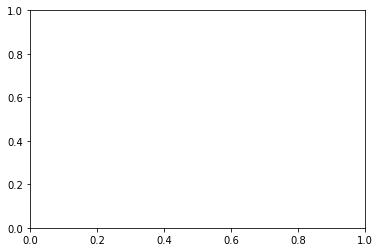

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
x=range(epochs)
y1=trained_costs
y2=trained_va_costs
ax.plot(x,y1, label='train') 
ax.plot(x, y2, label='validation') 
ax.set_xlabel('epochs')
ax.set_ylabel('loss')
ax.set_title('Cost')
ax.legend()

plt.show()

In [ ]:
fig, ax = plt.subplots()
x=range(epochs)
y1=trained_accs
y2=trained_va_acc
ax.plot(x,y1, label='train') 
ax.plot(x,y2, label='validation') 
ax.set_xlabel('epochs')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy')
ax.legend()

plt.show()

# Test Data Loading

In [ ]:
file=['/content/drive/My Drive/cifar-10/test_batch']
Xte,Yte,yte=loadBatch(file)

In [ ]:

Xte=tf.cast(Xte,dtype=tf.float64)
Yte=tf.cast(Yte,dtype=tf.float64)
yte=tf.cast(yte,dtype=tf.float64)

from numpy.core.fromnumeric import std
mean_Xte=tf.reduce_mean(Xte,1)
mean_Xte=tf.reshape(mean_Xte,[10000,1])
ones=tf.ones([1,3072],dtype=tf.float64)

mean_Xte=tf.matmul(mean_Xte,ones)
std_Xte=tf.math.reduce_std(Xte,1)
std_Xte=tf.reshape(std_Xte,[10000,1])
std_Xte=tf.matmul(std_Xte,ones)

Xte=tf.subtract(Xte,mean_Xte)
Xte=tf.divide(Xte,std_Xte)
